![image info](BCI.png)

# Classification of brain states (FOOT and HAND Movement) framework
--------------------------------------------------------------------------------------------------------------------------------

### Data
i. The framework uses the dataset of healthy control subjects performing imagery right hand and foot movement.

ii. The total number of signals corresponds to RIGHT HAND MOVEMENT is 400_000 while for RIGHT FOOT MOVEMENT it was 500_000. 

iii. Each class has 118 channels.

iv. Initial sampling rate = 1KHz, i.e. 1000 samples are captured in one second.

v. The data is downsampled to 100 Hz,  i.e. 100 samples in one second.

## Import required libraries (Note import is repeated to understand the required libraries are imported when specific module is implemented)

In [161]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install torch
!pip install PyWavelets
!pip install antropy
!pip install scipy

In [162]:
# Importing required libraries required to execution
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
import scipy.io
import warnings
warnings.filterwarnings('ignore') # ignoring warnings if any just to avoid confusion during the execution

### Load the data stored in .MAT file and assign respective classes

In [163]:
# Load the data which is stored in MAT file
BCI_data = scipy.io.loadmat('bci.mat')
RH = BCI_data['rh'] # Signals belonging to right hand (RH) movement
RF = BCI_data['rf'] # Signals belonging to right foot (RF) movement
print("RF: ", RF.shape)
print("RH: ",RH.shape)

RF:  (500000, 118)
RH:  (400000, 118)


In [164]:
def check_for_nans(matrix):
# Find NaN values in matrix2
    nan_mask = np.isnan(matrix)  # Boolean mask where NaNs are present

    # Get row and column indices of NaNs
    nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

    # Find which columns contain NaNs
    nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

    # Print results
    # Print results
    print(f"NaN values found in {len(nan_positions)} locations.")
    print(f"Columns with NaN values: {nan_columns.tolist()}")
    print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity
    
check_for_nans(RF)
check_for_nans(RH)

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []
NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [165]:
# Function to impute NaN values with column mean (for median imputation just replace nanmedian)
def impute_with_mean(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)
    
    # Calculate column means (ignoring NaNs)
    col_means = np.nanmean(matrix, axis=0)
    
    # Replace NaNs with corresponding column mean
    matrix[nan_mask] = np.take(col_means, np.where(nan_mask)[1])
    
    return matrix

def impute_with_interpolation(matrix):
    pData=pd.DataFrame(matrix)
    print(pData)
        

# Impute NaN values in both matrix1 and matrix2
RH_NANS_REMOVED = impute_with_mean(RH)
RF_NANS_REMOVED = impute_with_mean(RF)

### Verify if there are nan values

In [166]:
check_for_nans(RH_NANS_REMOVED)
check_for_nans(RF_NANS_REMOVED)

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []
NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [167]:
from scipy.stats import mode
### Code for mode-based imputation
def impute_with_mode(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)

    # Calculate column mode (ignoring NaNs)
    col_modes = np.array([mode(matrix[:, i], nan_policy='omit').mode[0] for i in range(matrix.shape[1])])

    # Replace NaNs with corresponding column mode
    matrix[nan_mask] = np.take(col_modes, np.where(nan_mask)[1])

    return matrix

# Usage
# RH = impute_with_mode(RH)
# RF = impute_with_mode(RF)

### Preprocessing using filtering

In [168]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, notch_freq, fs, quality_factor=20):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    y = filtfilt(b, a, data)
    return y

# sampling frequency in Hz. It is because of the nyquist theorem.
# We need double the frequency to sample
fs = 200

# Apply notch filter to suppress 50 Hz signal
filtered_RF = notch_filter(RF_NANS_REMOVED, 50, fs)
filtered_RH = notch_filter(RH_NANS_REMOVED, 50, fs)

# Apply bandpass filter between 0.5-30 Hz
filtered_signal_RF = bandpass_filter(filtered_RF, 0.5, 30, fs)
filtered_signal_RH = bandpass_filter(filtered_RH, 0.5, 30, fs)

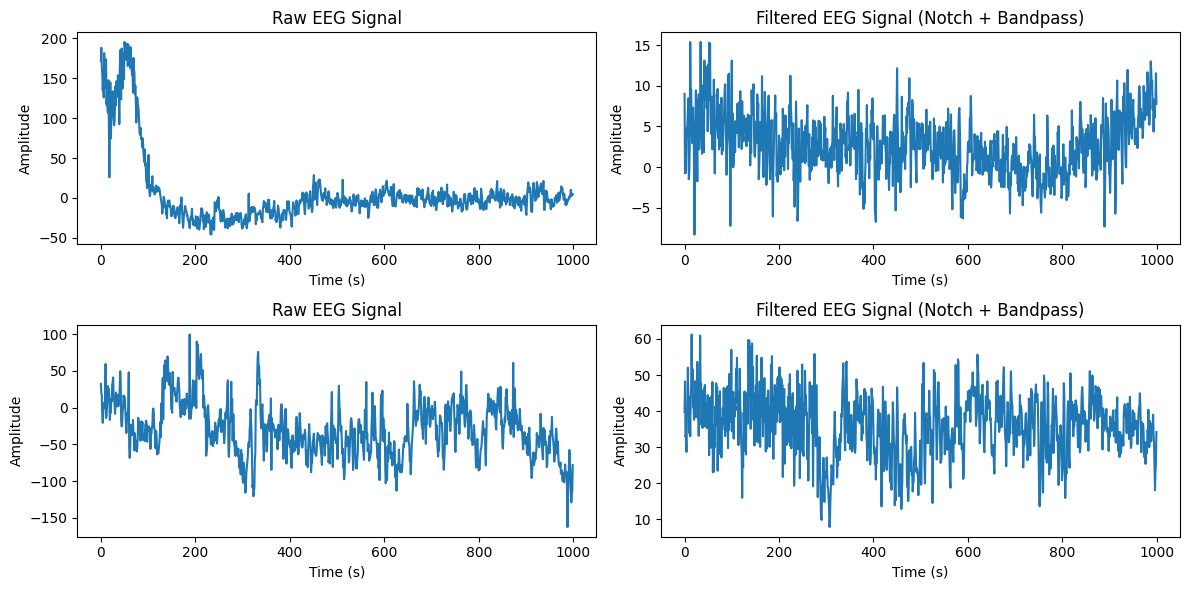

In [169]:
# Plot the raw and filtered signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(RF_NANS_REMOVED[5000:6000,84])
plt.title('Raw EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.plot(filtered_signal_RF[5000:6000,84])
plt.title('Filtered EEG Signal (Notch + Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.subplot(2, 2, 3)
plt.plot(RH_NANS_REMOVED[5000:6000,84])
plt.title('Raw EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 4)
plt.plot(filtered_signal_RH[5000:6000,84])
plt.title('Filtered EEG Signal (Notch + Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


### Select any one channel for analysis and reshape the data into 10 second long epoch

#### Final obtained signal

i. 400 signals belongs to right hand class

ii. 500 signals belongs to right foot class

iii. Therefore, a total of 900 signals for right hand and right foot

In [170]:
# Reshape the data and only select any one channel for simplicity
 
# Select any one channel but not the channel should be same for RH and RF
Right_hand = filtered_signal_RH[:,2:7]
# Select any one channel but not the channel should be same for RH and RF
Right_foot = filtered_signal_RF[:,2:7]

# Reshape the right hand data of 5 channels into 10 second (100 Hz *10 sec)
Right_hand = Right_hand.reshape(400, 1000,5)
# Reshape the right foot data of 5 channels into 10 second (100 Hz *10 sec)
Right_foot = Right_foot.reshape(500, 1000,5)
# Each sample has 1000 feature values

print(f"Right hand data shape: {Right_hand.shape}")
print(f"Right foot data shape: {Right_foot.shape}")

Right hand data shape: (400, 1000, 5)
Right foot data shape: (500, 1000, 5)


In [171]:
Y = np.concatenate((np.zeros((400,1)), np.ones((500,1))), axis=0) 

### Now create a binary labels indicating RH and RF

In [172]:

X_ch2 = np.concatenate((Right_hand[:,:,0],Right_foot[:,:,0])) # 0 indicate RH and 1 indicate RF
X_ch3 = np.concatenate((Right_hand[:,:,1],Right_foot[:,:,1]))
X_ch4 = np.concatenate((Right_hand[:,:,2],Right_foot[:,:,2]))
X_ch5 = np.concatenate((Right_hand[:,:,3],Right_foot[:,:,3]))
X_ch6 = np.concatenate((Right_hand[:,:,4],Right_foot[:,:,4]))
X = np.array([X_ch2, X_ch3, X_ch4, X_ch5, X_ch6])

## This section indicate feature extraction 

#### Statistical Features

In [173]:
import scipy.stats as stats

In [174]:
# Statistical Features
def extract_statistical_features(signal):
    mean = np.mean(signal)
    median = np.median(signal)
    std_dev = np.std(signal)
    variance = np.var(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    range_val = np.ptp(signal)
    
    features = {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Variance': variance,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Range': range_val
    }
    
    return features

stat_features = np.array([extract_statistical_features(signal) for ch in X for signal in ch])
stat_features = stat_features.reshape(-1, len(X[0]))
print(stat_features.shape)


(5, 900)


#### Time Domain Features

In [227]:
# Time Domain Features
def extract_time_domain_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    autocorrelation = np.correlate(signal, signal, mode='full')[len(signal)-1]
    mean_abs_dev = np.mean(np.abs(signal - np.mean(signal)))
    max_val = np.max(signal)
    min_val = np.min(signal)
    signal_energy = np.sum(signal**2)
    
    features = {
        'RMS': rms,
        'Zero Crossings': zero_crossings,
        'Autocorrelation': autocorrelation,
        'Mean Absolute Deviation': mean_abs_dev,
        'Max Value': max_val,
        'Min Value': min_val,
        'Signal Energy': signal_energy
    }
    
    return features

time_features = np.array([extract_time_domain_features(signal) for ch in X for signal in ch])
print(time_features.shape)
time_features = time_features.reshape(-1, len(X[0]))
print(time_features.shape)


# time_features_2 = [extract_time_domain_features(signal) for signal in X_ch2]
# time_features_3 = [extract_time_domain_features(signal) for signal in X_ch3]
# time_features_4 = [extract_time_domain_features(signal) for signal in X_ch4]
# time_features_5 = [extract_time_domain_features(signal) for signal in X_ch5]
# time_features_6 = [extract_time_domain_features(signal) for signal in X_ch6]

(4500,)
(5, 900)


#### Frequency Domain Features

In [176]:
from scipy.signal import welch


def extract_frequency_domain_features(signal):
    fs = 100
    freqs, psd = welch(signal, fs)
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    band_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])
    mean_freq = np.mean(freqs)
    median_freq = np.median(freqs)
    peak_freq = freqs[np.argmax(psd)]
    freq_variance = np.var(freqs)
    
    features = {
        'Dominant Frequency': dominant_freq,
        'Total Power': total_power,
        'Band Power (0.5-40 Hz)': band_power,
        'Mean Frequency': mean_freq,
        'Median Frequency': median_freq,
        'Peak Frequency': peak_freq,
        'Frequency Variance': freq_variance
    }
    
    return features

print(type(X[0][0]))
freq_features = np.array([extract_frequency_domain_features(signal) for ch in X for signal in ch])
freq_features = freq_features.reshape(-1, len(X[0]))
print(freq_features.shape)

<class 'numpy.ndarray'>
(5, 900)


In [177]:
import pywt
import antropy as ant

#### Entropy Features

In [178]:
# Entropy Features
def extract_entropy_features(signal):
    fs = 100
    sample_entropy = ant.sample_entropy(signal)
    spectral_entropy = ant.spectral_entropy(signal, sf=fs, method='welch')
    perm_entropy = ant.perm_entropy(signal, normalize=True)
    svd_entropy = ant.svd_entropy(signal, order=3, delay=1)
    app_entropy = ant.app_entropy(signal)
    lziv_complexity = ant.lziv_complexity(signal)
    
    features = {
        'Sample Entropy': sample_entropy,
        'Spectral Entropy': spectral_entropy,
        'Permutation Entropy': perm_entropy,
        'SVD Entropy': svd_entropy,
        'Approximate Entropy': app_entropy,
        'LZiv Complexity': lziv_complexity
    }
    
    return features

entropy_features = np.array([extract_entropy_features(signal) for ch in X for signal in ch])
entropy_features = entropy_features.reshape(-1, len(X[0]))
print(entropy_features.shape)

(5, 900)


### Feature concatenation 

In [ ]:
# Combine all features into a single DataFrame
def combine_features(stat_features, time_features, freq_features, entropy_features):
    combined_features_list = []
    for i in range(len(stat_features)):
        combined_features = {**stat_features[i], **time_features[i], **freq_features[i], **entropy_features[i], }
        combined_features_list.append(combined_features)
    return pd.DataFrame(combined_features_list)

combined_features_df = np.array([combine_features(stat_features[i], time_features[i], freq_features[i], entropy_features[i]) for i in range(5)])


print("Combined Features DataFrame:")
print(combined_features_df.shape)

Combined Features DataFrame:
(5, 900, 27)


In [180]:
# Reshape the data to have samples, then channels, and then features
# Assuming Right_hand and Right_foot are already defined and reshaped

# Combine the data for right hand and right foot
#combined_data = np.concatenate((Right_hand, Right_foot), axis=0)

# Transpose the data to have samples, channels, and then features
reshaped_data = combined_features_df.transpose(1, 0, 2)
reshaped_data=reshaped_data.reshape(900,-1)

print(f"Reshaped data shape: {reshaped_data.shape}")

Reshaped data shape: (900, 135)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create DataFrame
def normalize(reshape_df):
    df = pd.DataFrame(reshape_df)

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Apply the scaler to normalize the data
    normalized_data = scaler.fit_transform(df)

    # Convert the result back into a DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
    # print(normalized_df)
    return normalized_df

normalized_df=normalize(reshaped_data)
print(normalized_df.shape)


(900, 135)


### Feature selection

In [182]:
# Import necessary libraries
from sklearn.decomposition import PCA
import seaborn as sns

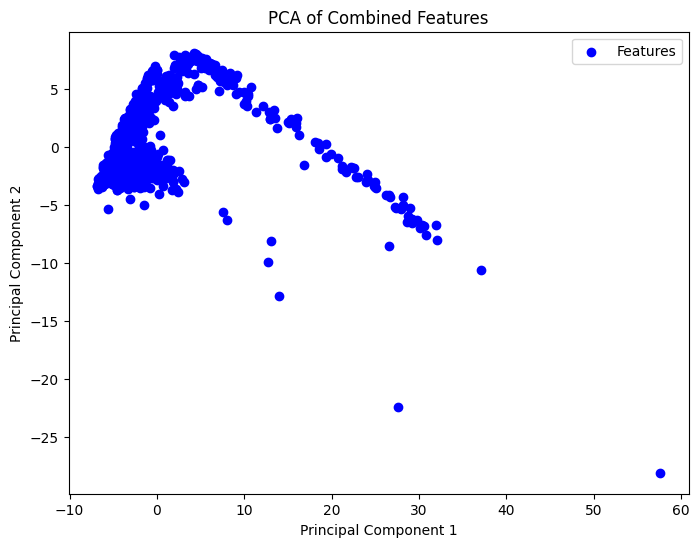

(900, 2)


In [183]:
# Apply PCA
def use_PCA(normalized_df):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(normalized_df)
    # Plot PCA
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', label='Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Combined Features')
    plt.legend()
    plt.savefig('PCA')
    plt.show()
    return pca_result

#pca_result = np.array([use_PCA(reshaped_data[i]) for i in range(5)])
pca_result=use_PCA(normalized_df)
print(pca_result.shape)

In [184]:
# Perform Kruskal-Wallis test
# kruskal_results = {}
# for feature in normalized_df.columns:
#     class_0 = normalized_df[feature][:400]
#     class_1 = normalized_df[feature][401:]
#     kruskal_results[feature] = stats.kruskal(class_0, class_1).pvalue

# # Export Kruskal-Wallis test results to Excel
# kruskal_results_df = pd.DataFrame(list(kruskal_results.items()), columns=['Feature', 'P-value'])
# kruskal_results_df.to_excel('kruskal_wallis_results.xlsx', index=False)
# print("Kruskal-Wallis test results have been exported to 'kruskal_wallis_results.xlsx'.")

In [185]:
# Plot box plots for each feature
# plt.figure(figsize=(12, 8))
# normalized_df['Class'] = Y
# melted_df = pd.melt(normalized_df, id_vars='Class', var_name='Feature', value_name='Value')
# sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
# plt.xticks(rotation=90)
# plt.title('Box Plots of Features for Two Classes')
# plt.savefig('KW_test')
# plt.show()

In [186]:
# Filter to include only 'Feature1'
# features_to_plot = ['LZiv Complexity', 'Standard Deviation', 'Min Value', 'Sample Entropy']
# normalized_df['Class'] = Y
# melted_df = pd.melt(normalized_df, id_vars='Class', var_name='Feature', value_name='Value')
# melted_df = melted_df[melted_df['Feature'].isin(features_to_plot)]
# sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
# plt.xticks(rotation=90)
# plt.title('Box Plot of Two Classes')
# plt.savefig('box_plot_feature1.png')
# plt.show()

In [187]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [205]:
# Initialize the model
model = RandomForestClassifier()

# Initialize RFE with the model and number of features to select
rfe = RFE(model, n_features_to_select=7)

# Fit RFE\
print(normalized_df.shape)
rfe = rfe.fit(normalized_df, Y)

# Get the selected features
selected_features = normalized_df.columns[rfe.support_]
print("Selected Features:", selected_features)

(900, 135)
Selected Features: Index([0, 16, 43, 53, 70, 97, 124], dtype='int64')


In [209]:
normalized_selected_features = np.array([normalized_df[selected_features[i]] for i in range(len(selected_features))])
normalized_selected_features = np.reshape(normalized_selected_features, (900, -1))
print(normalized_selected_features.shape)

(900, 7)


### Classification using SVM (linear and nonlinear)

In [207]:
# Import SVM and train test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [215]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, Y, test_size=0.2, random_state=42)
# Suing 70% data for trainig and 30% data for testing

In [212]:
# Initialize linear and nonlinear SVM models
linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Fit the models with the selected features
linear_svm.fit(X_train, y_train)
nonlinear_svm.fit(X_train, y_train)

# Evaluate the models
linear_score = linear_svm.score(X_test, y_test)
nonlinear_score = nonlinear_svm.score(X_test, y_test)
print("Linear SVM Accuracy:", linear_score)
print("Nonlinear SVM Accuracy:", nonlinear_score)

Linear SVM Accuracy: 0.5444444444444444
Nonlinear SVM Accuracy: 0.6111111111111112


In [232]:
from sklearn.neighbors import KNeighborsClassifier

# Combine all features into a single DataFrame
def combine_features(time_features, freq_features):
    combined_features_list = []
    for i in range(len(time_features)):
        combined_features = {**time_features[i], **freq_features[i]}
        combined_features_list.append(combined_features)
    return pd.DataFrame(combined_features_list)

print(f"Time shape: {time_features.shape}")
print(f"Freq shape: {freq_features.shape}")

combined_features_df = np.array([combine_features(time_features[i], freq_features[i]) for i in range(5)])

print(combined_features_df.shape)

reshaped_data = combined_features_df.transpose(1, 0, 2)
reshaped_data=reshaped_data.reshape(900,-1)

print(f"Combined Features shape: {combined_features_df.shape}")
normalized_df=normalize(reshaped_data)

print("Combined Features DataFrame:")
print(combined_features_df.shape)

normalized_df = np.reshape(normalized_df, (900, -1))
print(normalized_df.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(normalized_df, Y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print("KNN Accuracy:", knn_score)

Time shape: (5, 900)
Freq shape: (5, 900)
(5, 900, 14)
Combined Features shape: (5, 900, 14)
Combined Features DataFrame:
(5, 900, 14)
(900, 70)
(900, 1)
KNN Accuracy: 0.9222222222222223


In [ ]:
def plot_decision_boundary(clf, X, y, name):
    # Convert X to NumPy array if it's a DataFrame
    if hasattr(X, "values"):
        X = X.values

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on grid points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contours
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')  # Decision boundary

    # Scatter plot of data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(name)
    plt.savefig(name)
    plt.show()


plot_decision_boundary(knn, X_train, y_train,'SVM_Linear')


ValueError: X has 2 features, but SVC is expecting 7 features as input.

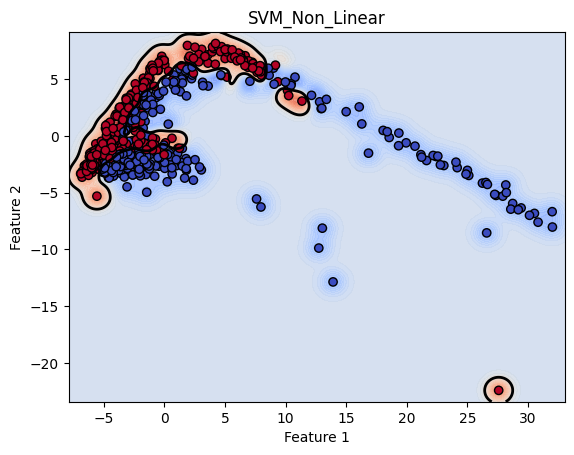

In [193]:
plot_decision_boundary(nonlinear_svm, X_train, y_train,'SVM_Non_Linear')

### Plot Confusion Matrix

In [ ]:
np.

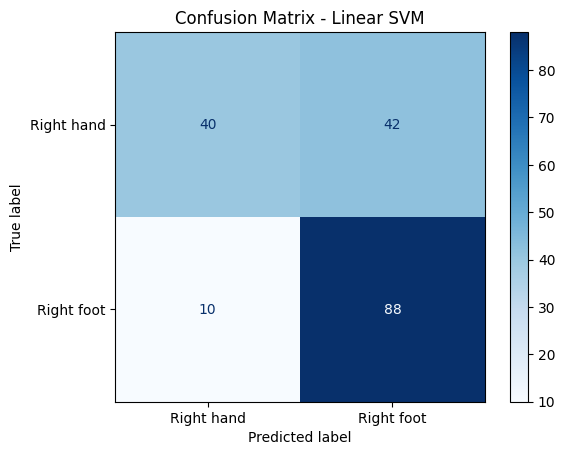

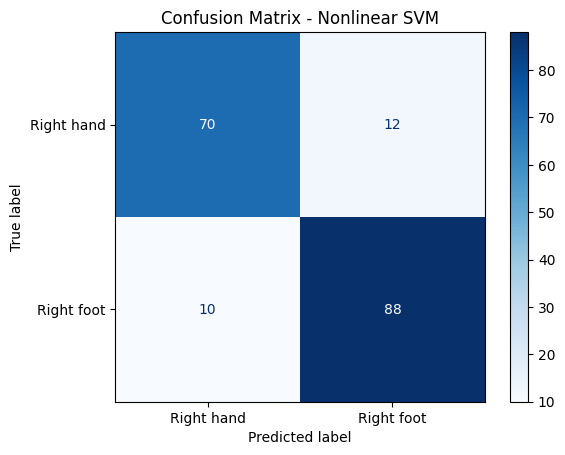

In [194]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrices for both models
y_pred_linear = linear_svm.predict(X_test)
y_pred_nonlinear = nonlinear_svm.predict(X_test)

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_nonlinear = confusion_matrix(y_test, y_pred_nonlinear)

disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear,
                                     display_labels=['Right hand', 'Right foot'])
disp_nonlinear = ConfusionMatrixDisplay(confusion_matrix=cm_nonlinear,
                                        display_labels=['Right hand', 'Right foot'])

disp_linear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Linear SVM")
plt.savefig("CM_L_SVM")
plt.show()

disp_nonlinear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Nonlinear SVM")
plt.savefig("CM_NL_SVM")
plt.show()

### Classification Report

In [195]:
from sklearn.metrics import classification_report
report_linear = classification_report(y_test, y_pred_linear, target_names=['Right hand', 'Right foot'])
report_nonlinear = classification_report(y_test, y_pred_nonlinear, target_names=['Right hand', 'Right foot'])
print(report_linear)
print(report_nonlinear)

              precision    recall  f1-score   support

  Right hand       0.80      0.49      0.61        82
  Right foot       0.68      0.90      0.77        98

    accuracy                           0.71       180
   macro avg       0.74      0.69      0.69       180
weighted avg       0.73      0.71      0.70       180

              precision    recall  f1-score   support

  Right hand       0.88      0.85      0.86        82
  Right foot       0.88      0.90      0.89        98

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180



### ROC AUC Curve

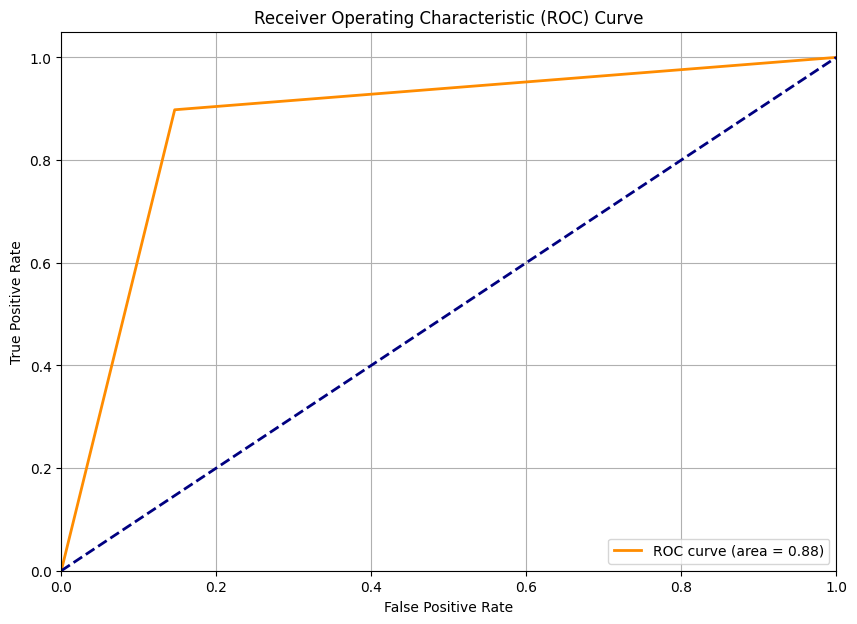

In [196]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_nonlinear)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with detailed annotations

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)



### Training with Entire data

In [197]:
X_train, X_test, y_train, y_test = train_test_split(normalized_data, Y, test_size=0.2, random_state=42)
# Suing 70% data for trainig and 30% data for testing

# Initialize linear and nonlinear SVM models
linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Fit the models with the selected features
linear_svm.fit(X_train, y_train)
nonlinear_svm.fit(X_train, y_train)

# Evaluate the models
linear_score = linear_svm.score(X_test, y_test)
nonlinear_score = nonlinear_svm.score(X_test, y_test)
print("Linear SVM Accuracy:", linear_score)
print("Nonlinear SVM Accuracy:", nonlinear_score)

Linear SVM Accuracy: 0.9888888888888889
Nonlinear SVM Accuracy: 0.9833333333333333


### Validation using 10-fold cross validation

In [198]:
from sklearn.model_selection import cross_val_score, KFold
# Define SVM classifier
svm_model = SVC(kernel='rbf',C=0.3, gamma=0.3,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a plot for ROC
plt.figure(figsize=(12, 8))

# Initialize a matrix to store the combined confusion matrix
combined_confusion_matrix = np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int)

# Initialize lists to store all true labels and predicted probabilities
y_true_combined = []
y_pred_prob_combined = []


# Perform cross-validation manually to access each fold
for fold, (train_index, test_index) in enumerate(kf.split(normalized_data), start=1):
    X_train, X_test = normalized_data[train_index], normalized_data[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Get probability predictions for ROC curve
    y_prob = svm_model.predict_proba(X_test)
    
    # Append true labels and predicted probabilities to combined lists
    y_true_combined.extend(y_test)
    y_pred_prob_combined.extend(y_prob)
    
    # Calculate confusion matrix for this fold
    cm = confusion_matrix(y_test, svm_model.predict(X_test))
    
    # Combine confusion matrix (sum them)
    combined_confusion_matrix += cm
    
    # Print confusion matrix for this fold
    print(f'Confusion Matrix for Fold {fold}:\n{cm}')
    print('-' * 50)

# Print the combined confusion matrix
print(f'Combined Confusion Matrix across all folds:\n{combined_confusion_matrix}')

Confusion Matrix for Fold 1:
[[42  1]
 [ 0 47]]
--------------------------------------------------
Confusion Matrix for Fold 2:
[[38  1]
 [ 1 50]]
--------------------------------------------------
Confusion Matrix for Fold 3:
[[38  1]
 [ 1 50]]
--------------------------------------------------
Confusion Matrix for Fold 4:
[[44  0]
 [ 4 42]]
--------------------------------------------------
Confusion Matrix for Fold 5:
[[42  0]
 [ 3 45]]
--------------------------------------------------
Confusion Matrix for Fold 6:
[[45  1]
 [ 2 42]]
--------------------------------------------------
Confusion Matrix for Fold 7:
[[36  0]
 [ 2 52]]
--------------------------------------------------
Confusion Matrix for Fold 8:
[[32  0]
 [ 7 51]]
--------------------------------------------------
Confusion Matrix for Fold 9:
[[38  1]
 [ 3 48]]
--------------------------------------------------
Confusion Matrix for Fold 10:
[[39  1]
 [ 3 47]]
--------------------------------------------------
Combined 

<Figure size 1200x800 with 0 Axes>

### Grid Search for best parameter selection

In [199]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the SVM model
svm = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Kernel type
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the best model on the full training set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the final model
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.976543209876543
Test Accuracy: 0.9777777777777777
